# Querying the *flight phase files*

In [1]:
%load_ext autoreload
%autoreload 2;

Let's import some modules, that we need for the following examples:

In [2]:
import ac3airborne as ac3a
import flightphase as fp
import pandas as pd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import xarray as xr

In order to select a flight and import its flight segments just use the corresponding method of the module *ac3airborne*.

In [3]:
campaign = 'ACLOUD'
aircraft = 'P5'
number   = 'RF14'
date     = '20170608'
flight   = campaign + '_' + aircraft + '_' + number

meta = ac3a.get_flight_segments()

yaml_content = meta[aircraft][flight]

We introduce here some new methods, that we will use to select the flight segments, querying for different criteria.

In [4]:
ds = fp.FlightPhaseFile(yaml_content)

We read the gps data of the whole flight

In [5]:
# read gps data
file = '~/ac3airborne/campaigns/'+campaign.lower()+'/'+aircraft.lower()+'/gps_ins/'+campaign+'_polar'+aircraft[1]+'_'+date+'_'+number+'.nc'
ds_gps = xr.open_dataset(file)

Plot the flight

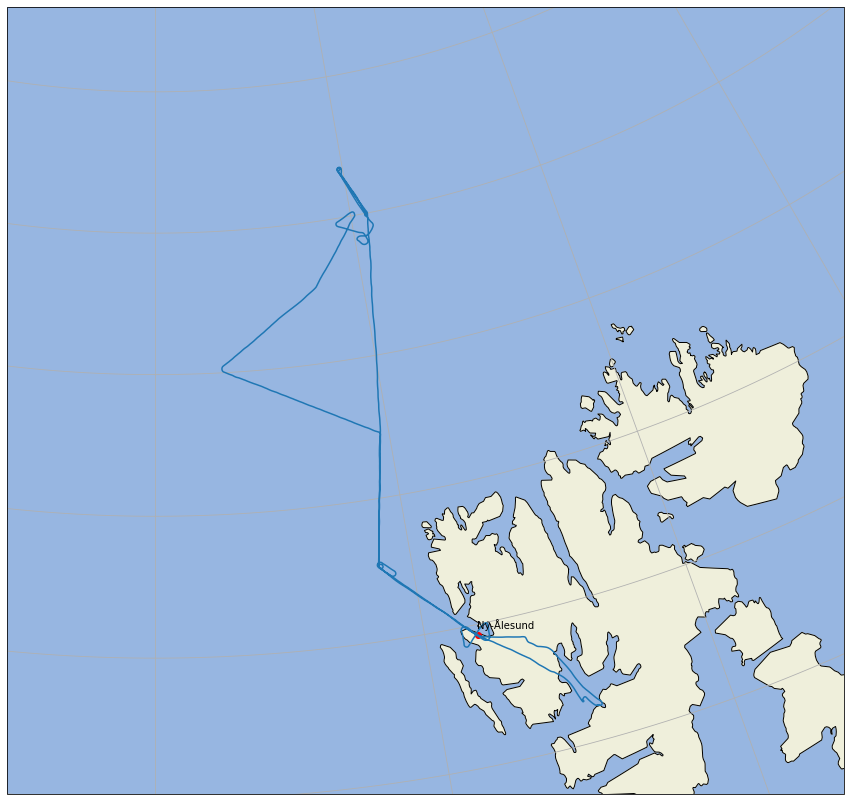

In [6]:
proj   = ccrs.NorthPolarStereo()
extent = (-5.0, 24.0, 78.0, 83.0)

fig = plt.figure(figsize=(15, 15))
ax = plt.axes(projection=proj)
ax.set_extent(extent)

ax.add_feature(cfeature.OCEAN)
ax.add_feature(cfeature.LAND)
ax.gridlines()
ax.coastlines()

nya_lat = 78.924444
nya_lon = 11.928611

ax.plot(nya_lon, nya_lat, 'ro', transform=ccrs.PlateCarree())
ax.text(nya_lon, nya_lat+0.05, 'Ny-Ålesund', transform=ccrs.PlateCarree())

line_all = ax.plot(ds_gps.lon, ds_gps.lat, transform=ccrs.PlateCarree())

### Query all segments of a specific kind

Example with one kind

In [7]:
queried = ds.selectKind(['high_level'])

df = pd.DataFrame(queried)
df

,dropsondes,end,irregularities,kinds,levels,name,parts,segment_id,start
0,"{'BAD': [], 'GOOD': [], 'UGLY': []}",2017-06-08 08:25:57,[],[high_level],[9800],high level 1,[],ACLOUD_P5_RF14_hl01,2017-06-08 08:08:54
1,"{'BAD': [], 'GOOD': ['P5_RF14_sonde02'], 'UGLY...",2017-06-08 08:58:26,[],[high_level],[9800],high level 2,[],ACLOUD_P5_RF14_hl02,2017-06-08 08:36:30
2,"{'BAD': [], 'GOOD': ['P5_RF14_sonde03'], 'UGLY...",2017-06-08 09:30:30,[],"[high_level, a-train_underflight]",[9700],high level 3,[],ACLOUD_P5_RF14_hl03,2017-06-08 08:59:08
3,"{'BAD': [], 'GOOD': ['P5_RF14_sonde04'], 'UGLY...",2017-06-08 09:51:04,[],[high_level],[9700],high level 4,[],ACLOUD_P5_RF14_hl04,2017-06-08 09:31:41
4,"{'BAD': [], 'GOOD': ['P5_RF14_sonde05'], 'UGLY...",2017-06-08 10:00:14,[],[high_level],[9800],high level 5,[],ACLOUD_P5_RF14_hl05,2017-06-08 09:51:33
5,"{'BAD': ['P5_RF14_sonde06'], 'GOOD': [], 'UGLY...",2017-06-08 11:52:57,[],[high_level],[9700],high level 8,NaN,ACLOUD_P5_RF14_hl08,2017-06-08 11:11:20
6,"{'BAD': [], 'GOOD': ['P5_RF14_sonde07'], 'UGLY...",2017-06-08 12:05:14,[],[high_level],[9800],high level 9,NaN,ACLOUD_P5_RF14_hl09,2017-06-08 11:53:38


Plot the selected segments:

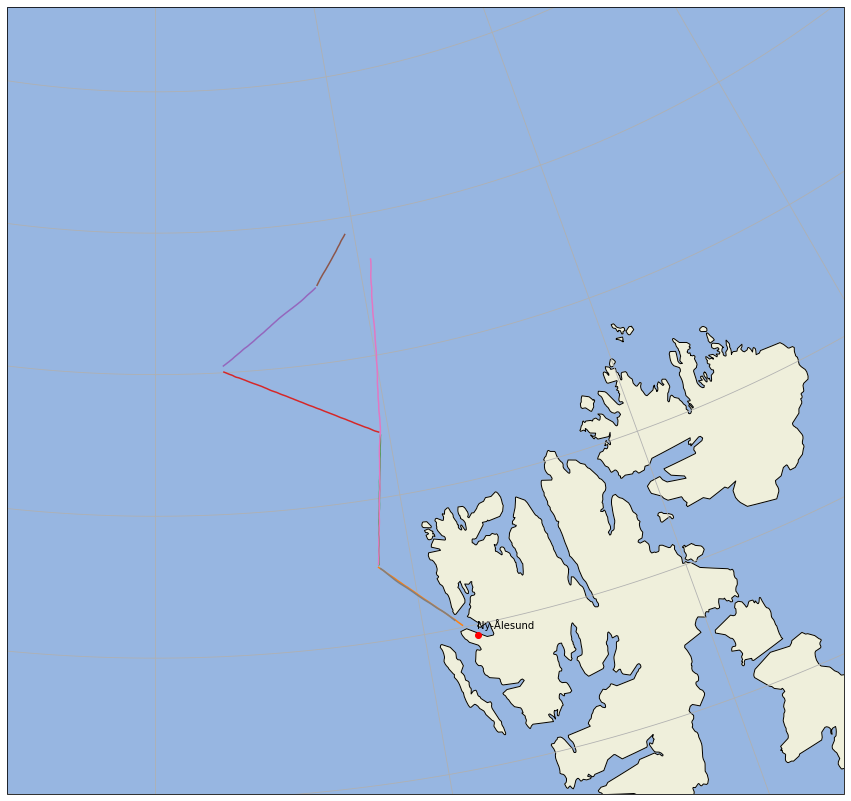

In [8]:
ll = line_all.pop(0)
ll.remove()

lines = []
for q in queried:
    start = q['start']
    end   = q['end']
    
    line = ax.plot(ds_gps.lon.sel(time=slice(start, end)),
                   ds_gps.lat.sel(time=slice(start, end)),
                   transform=ccrs.PlateCarree())
    lines.append(line)
    
fig

 Example with more than one kind

In [9]:
kinds = ['a-train_underflight', 'nya_overflight', 'polarstern_overflight']

queried = ds.selectKind(kinds)

df = pd.DataFrame(queried)
df

,dropsondes,end,irregularities,kinds,levels,name,segment_id,start,parts
0,"{'BAD': [], 'GOOD': [], 'UGLY': []}",2017-06-08 08:08:54,[whale-watching loop],"[major_ascend, nya_overflight, low_level_Sveab...","[100, 9700]",major ascend,ACLOUD_P5_RF14_ma,2017-06-08 07:36:50,NaN
1,"{'BAD': [], 'GOOD': ['P5_RF14_sonde03'], 'UGLY...",2017-06-08 09:30:30,[],"[high_level, a-train_underflight]",[9700],high level 3,ACLOUD_P5_RF14_hl03,2017-06-08 08:59:08,[]
2,NaN,2017-06-08 10:10:51,[],"[cross_pattern, polarstern_overflight]","[9600, 9700]",cross pattern 1,ACLOUD_P5_RF14_cp01,2017-06-08 10:00:14,"[{'end': 2017-06-08 10:03:14, 'irregularities'..."
3,"{'BAD': [], 'GOOD': [], 'UGLY': []}",2017-06-08 12:25:40,[],"[cross_pattern, nya_overflight]","[9800, 9800, 9800]",cross pattern 2,ACLOUD_P5_RF14_cp02,2017-06-08 12:05:14,"[{'end': 2017-06-08 12:10:14, 'irregularities'..."


Plot the selected segments:

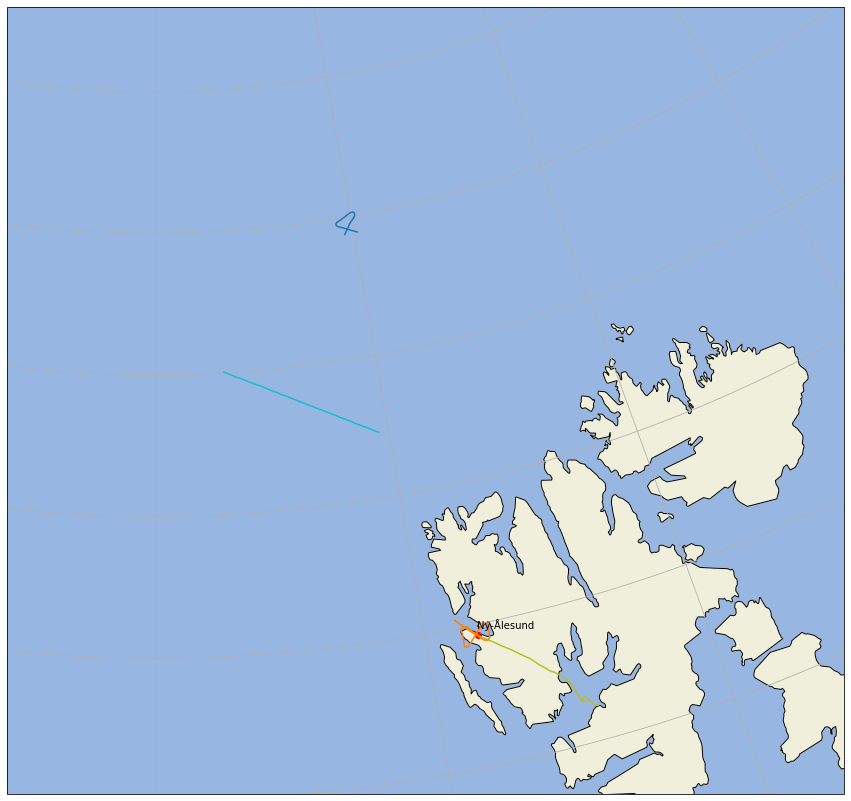

In [10]:
for l in lines:
    ll = l.pop(0)
    ll.remove()
    
lines = []
for q in queried:
    start = q['start']
    end   = q['end']
    
    line = ax.plot(ds_gps.lon.sel(time=slice(start, end)),
                   ds_gps.lat.sel(time=slice(start, end)),
                   transform=ccrs.PlateCarree())
    lines.append(line)
    
fig

### Sorting out all segments given a list of kinds

In [11]:
sort_out = ['short_turn', 'holding_pattern', 'major_ascend', 'major_descend', 'high_level']

queried = ds.selectKind(sort_out, invertSelection=True)

df = pd.DataFrame(queried)
df

,end,irregularities,kinds,levels,name,parts,segment_id,start,dropsondes
0,2017-06-08 10:10:51,[],"[cross_pattern, polarstern_overflight]","[9600, 9700]",cross pattern 1,"[{'end': 2017-06-08 10:03:14, 'irregularities'...",ACLOUD_P5_RF14_cp01,2017-06-08 10:00:14,NaN
1,2017-06-08 10:22:44,[not along straight line],[large_descend],"[9700, 200]",large descend,NaN,ACLOUD_P5_RF14_ld01,2017-06-08 10:10:51,"{'BAD': [], 'GOOD': [], 'UGLY': []}"
2,2017-06-08 11:02:02,[],[racetrack pattern],"[200, 300, 1500, 2400]",racetrack pattern 1,"[{'end': 2017-06-08 10:29:21, 'irregularities'...",ACLOUD_P5_RF14_rt01,2017-06-08 10:22:44,"{'BAD': [], 'GOOD': [], 'UGLY': []}"
3,2017-06-08 11:11:20,[],[large_ascend],"[2400, 9700]",large ascend 2,NaN,ACLOUD_P5_RF14_la02,2017-06-08 11:02:25,"{'BAD': [], 'GOOD': [], 'UGLY': []}"
4,2017-06-08 12:25:40,[],"[cross_pattern, nya_overflight]","[9800, 9800, 9800]",cross pattern 2,"[{'end': 2017-06-08 12:10:14, 'irregularities'...",ACLOUD_P5_RF14_cp02,2017-06-08 12:05:14,"{'BAD': [], 'GOOD': [], 'UGLY': []}"


Plot the selected segments:

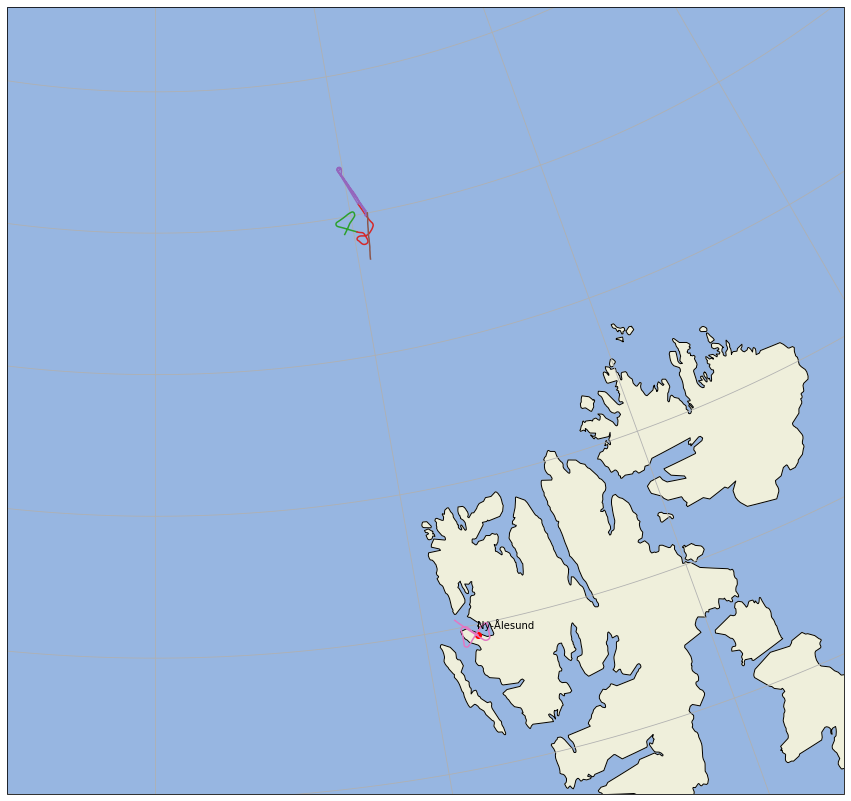

In [12]:
for l in lines:
    ll = l.pop(0)
    ll.remove()
    
lines = []
for q in queried:
    start = q['start']
    end   = q['end']
    
    line = ax.plot(ds_gps.lon.sel(time=slice(start, end)),
                   ds_gps.lat.sel(time=slice(start, end)),
                   transform=ccrs.PlateCarree())
    lines.append(line)
    
fig

### Query a segment with a specific value in a specific attribute

#### Example 1: Select element with specific name

In [13]:
attribute = 'name'
value = 'racetrack pattern 1'

queried = ds.select(attribute, value) 

df = pd.DataFrame(queried)
df

,dropsondes,end,irregularities,kinds,levels,name,parts,segment_id,start
0,"{'BAD': [], 'GOOD': [], 'UGLY': []}",2017-06-08 11:02:02,[],[racetrack pattern],"[200, 300, 1500, 2400]",racetrack pattern 1,"[{'end': 2017-06-08 10:29:21, 'irregularities'...",ACLOUD_P5_RF14_rt01,2017-06-08 10:22:44


Plot the selected elements:

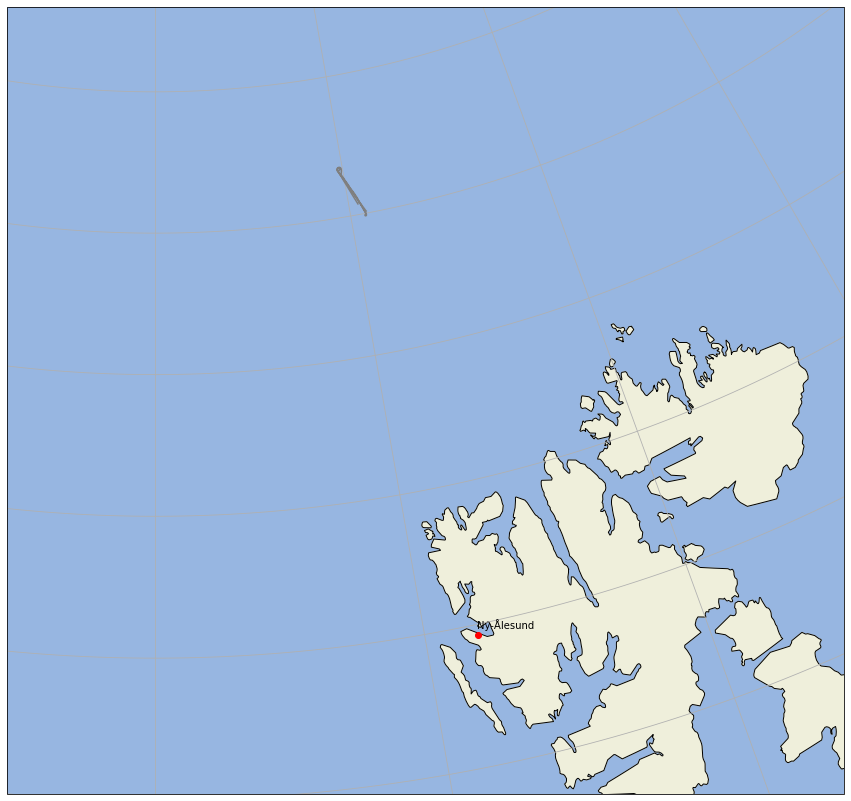

In [14]:
for l in lines:
    ll = l.pop(0)
    ll.remove()
    
lines = []
for q in queried:
    start = q['start']
    end   = q['end']
    
    line = ax.plot(ds_gps.lon.sel(time=slice(start, end)),
                   ds_gps.lat.sel(time=slice(start, end)),
                   transform=ccrs.PlateCarree())
    lines.append(line)
    
fig

Also with inverted selection

In [15]:
queried = ds.select(attribute, value, invertSelection=True) 

df = pd.DataFrame(queried)
df

,dropsondes,end,irregularities,kinds,levels,name,segment_id,start,parts
0,"{'BAD': [], 'GOOD': [], 'UGLY': []}",2017-06-08 08:08:54,[whale-watching loop],"[major_ascend, nya_overflight, low_level_Sveab...","[100, 9700]",major ascend,ACLOUD_P5_RF14_ma,2017-06-08 07:36:50,NaN
1,"{'BAD': [], 'GOOD': [], 'UGLY': []}",2017-06-08 08:25:57,[],[high_level],[9800],high level 1,ACLOUD_P5_RF14_hl01,2017-06-08 08:08:54,[]
2,"{'BAD': [], 'GOOD': [], 'UGLY': []}",2017-06-08 08:36:30,[],[holding_pattern],"[9800, 9800]",holding pattern 1,ACLOUD_P5_RF14_ho01,2017-06-08 08:25:57,"[{'end': 2017-06-08 08:27:33, 'kinds': ['short..."
3,"{'BAD': [], 'GOOD': ['P5_RF14_sonde02'], 'UGLY...",2017-06-08 08:58:26,[],[high_level],[9800],high level 2,ACLOUD_P5_RF14_hl02,2017-06-08 08:36:30,[]
4,NaN,2017-06-08 08:59:08,NaN,[short_turn],NaN,short turn,NaN,2017-06-08 08:58:26,NaN
5,"{'BAD': [], 'GOOD': ['P5_RF14_sonde03'], 'UGLY...",2017-06-08 09:30:30,[],"[high_level, a-train_underflight]",[9700],high level 3,ACLOUD_P5_RF14_hl03,2017-06-08 08:59:08,[]
6,NaN,2017-06-08 09:31:41,NaN,[short_turn],NaN,short turn,NaN,2017-06-08 09:30:30,NaN
7,"{'BAD': [], 'GOOD': ['P5_RF14_sonde04'], 'UGLY...",2017-06-08 09:51:04,[],[high_level],[9700],high level 4,ACLOUD_P5_RF14_hl04,2017-06-08 09:31:41,[]
8,NaN,2017-06-08 09:51:33,NaN,[short_turn],NaN,short turn,NaN,2017-06-08 09:51:04,NaN
9,"{'BAD': [], 'GOOD': ['P5_RF14_sonde05'], 'UGLY...",2017-06-08 10:00:14,[],[high_level],[9800],high level 5,ACLOUD_P5_RF14_hl05,2017-06-08 09:51:33,[]


Plot the selected elements:

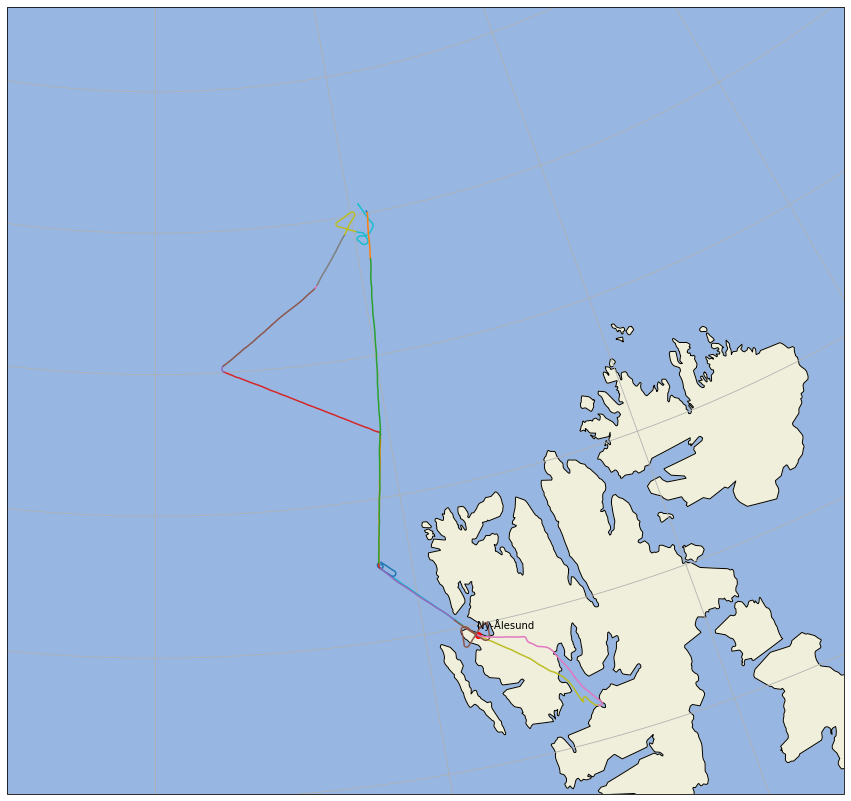

In [16]:
for l in lines:
    ll = l.pop(0)
    ll.remove()
    
lines = []
for q in queried:
    start = q['start']
    end   = q['end']
    
    line = ax.plot(ds_gps.lon.sel(time=slice(start, end)),
                   ds_gps.lat.sel(time=slice(start, end)),
                   transform=ccrs.PlateCarree())
    lines.append(line)
    
fig

#### Example 2: Specific level

In [17]:
attribute = 'levels'
value = 9800

queried = ds.select(attribute, value)

df = pd.DataFrame(queried)
df

,dropsondes,end,irregularities,kinds,levels,name,parts,segment_id,start
0,"{'BAD': [], 'GOOD': [], 'UGLY': []}",2017-06-08 08:25:57,[],[high_level],[9800],high level 1,[],ACLOUD_P5_RF14_hl01,2017-06-08 08:08:54
1,"{'BAD': [], 'GOOD': [], 'UGLY': []}",2017-06-08 08:36:30,[],[holding_pattern],"[9800, 9800]",holding pattern 1,"[{'end': 2017-06-08 08:27:33, 'kinds': ['short...",ACLOUD_P5_RF14_ho01,2017-06-08 08:25:57
2,"{'BAD': [], 'GOOD': ['P5_RF14_sonde02'], 'UGLY...",2017-06-08 08:58:26,[],[high_level],[9800],high level 2,[],ACLOUD_P5_RF14_hl02,2017-06-08 08:36:30
3,"{'BAD': [], 'GOOD': ['P5_RF14_sonde05'], 'UGLY...",2017-06-08 10:00:14,[],[high_level],[9800],high level 5,[],ACLOUD_P5_RF14_hl05,2017-06-08 09:51:33
4,"{'BAD': [], 'GOOD': ['P5_RF14_sonde07'], 'UGLY...",2017-06-08 12:05:14,[],[high_level],[9800],high level 9,NaN,ACLOUD_P5_RF14_hl09,2017-06-08 11:53:38
5,"{'BAD': [], 'GOOD': [], 'UGLY': []}",2017-06-08 12:25:40,[],"[cross_pattern, nya_overflight]","[9800, 9800, 9800]",cross pattern 2,"[{'end': 2017-06-08 12:10:14, 'irregularities'...",ACLOUD_P5_RF14_cp02,2017-06-08 12:05:14
6,"{'BAD': [], 'GOOD': [], 'UGLY': []}",2017-06-08 12:51:25,[],[major_descend],"[9800, 100]",major descend,NaN,ACLOUD_P5_RF14_md,2017-06-08 12:25:40


Plot the selected elements:

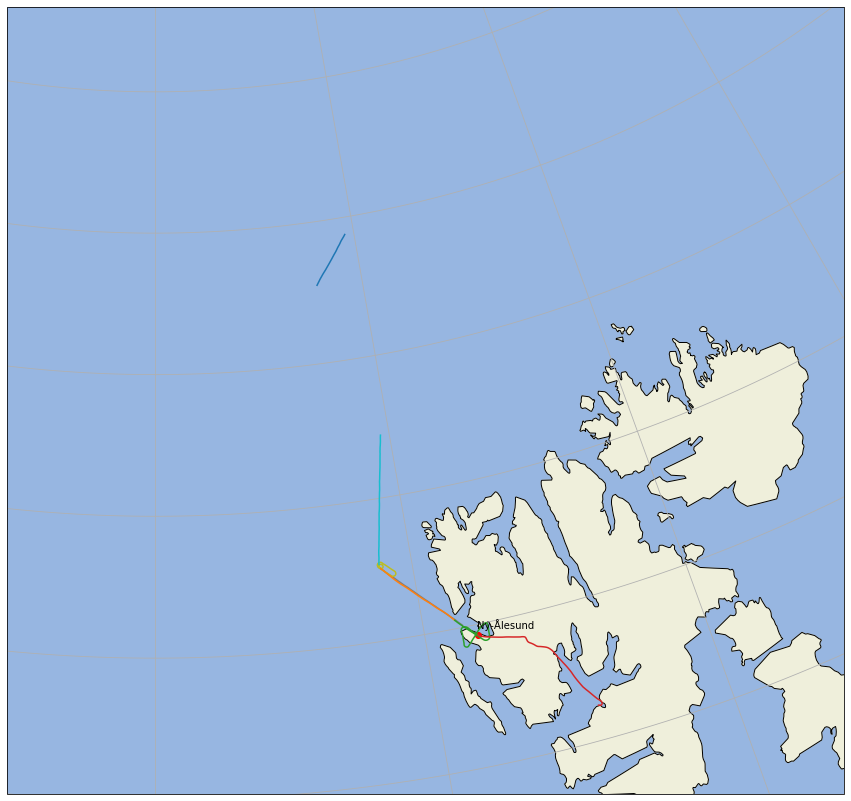

In [18]:
for l in lines:
    ll = l.pop(0)
    ll.remove()
    
lines = []
for q in queried:
    start = q['start']
    end   = q['end']
    
    line = ax.plot(ds_gps.lon.sel(time=slice(start, end)),
                   ds_gps.lat.sel(time=slice(start, end)),
                   transform=ccrs.PlateCarree())
    lines.append(line)
    
fig

But what if we want only a specific level without ascend and descend? We can require that the attribute value is strictly equal to the one, that we give, i.e. thare no other values:

In [19]:
queried = ds.select(attribute, value, strict=True)

df = pd.DataFrame(queried)
df

,dropsondes,end,irregularities,kinds,levels,name,parts,segment_id,start
0,"{'BAD': [], 'GOOD': [], 'UGLY': []}",2017-06-08 08:25:57,[],[high_level],[9800],high level 1,[],ACLOUD_P5_RF14_hl01,2017-06-08 08:08:54
1,"{'BAD': [], 'GOOD': ['P5_RF14_sonde02'], 'UGLY...",2017-06-08 08:58:26,[],[high_level],[9800],high level 2,[],ACLOUD_P5_RF14_hl02,2017-06-08 08:36:30
2,"{'BAD': [], 'GOOD': ['P5_RF14_sonde05'], 'UGLY...",2017-06-08 10:00:14,[],[high_level],[9800],high level 5,[],ACLOUD_P5_RF14_hl05,2017-06-08 09:51:33
3,"{'BAD': [], 'GOOD': ['P5_RF14_sonde07'], 'UGLY...",2017-06-08 12:05:14,[],[high_level],[9800],high level 9,NaN,ACLOUD_P5_RF14_hl09,2017-06-08 11:53:38


This functions only if the attribute has more values, as for level or kind. Now plot the selected elements:

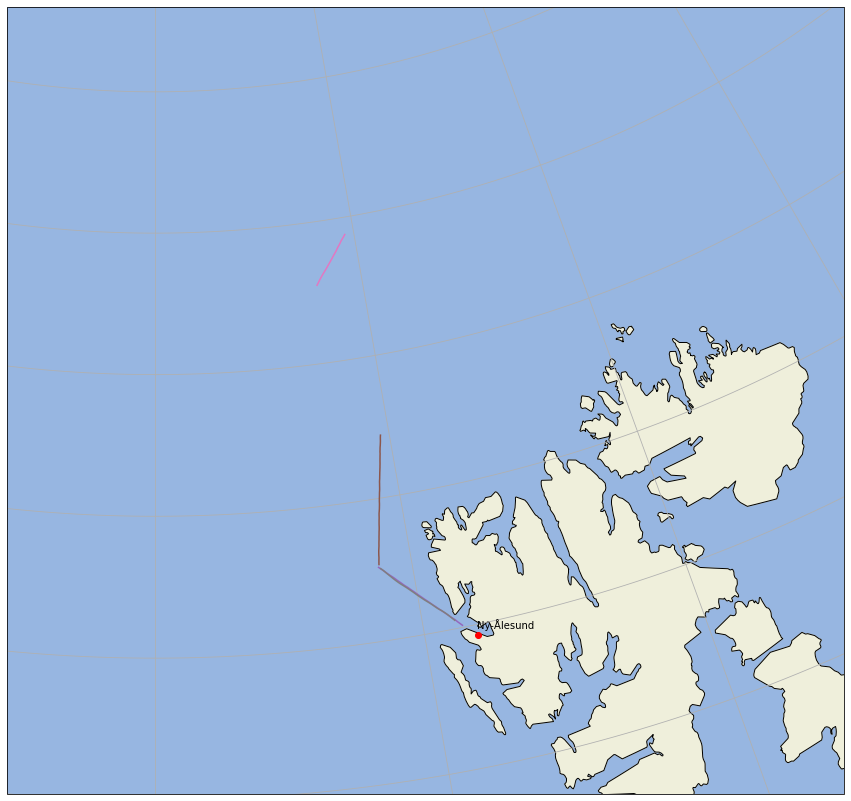

In [20]:
for l in lines:
    ll = l.pop(0)
    ll.remove()
    
lines = []
for q in queried:
    start = q['start']
    end   = q['end']
    
    line = ax.plot(ds_gps.lon.sel(time=slice(start, end)),
                   ds_gps.lat.sel(time=slice(start, end)),
                   transform=ccrs.PlateCarree())
    lines.append(line)
    
fig

### Query all segments with good (or bad) dropsondes

In [21]:
queried = ds.selectDropSondes('GOOD')

df = pd.DataFrame(queried)
df

,dropsondes,end,irregularities,kinds,levels,name,parts,segment_id,start
0,"{'BAD': [], 'GOOD': ['P5_RF14_sonde02'], 'UGLY...",2017-06-08 08:58:26,[],[high_level],[9800],high level 2,[],ACLOUD_P5_RF14_hl02,2017-06-08 08:36:30
1,"{'BAD': [], 'GOOD': ['P5_RF14_sonde03'], 'UGLY...",2017-06-08 09:30:30,[],"[high_level, a-train_underflight]",[9700],high level 3,[],ACLOUD_P5_RF14_hl03,2017-06-08 08:59:08
2,"{'BAD': [], 'GOOD': ['P5_RF14_sonde04'], 'UGLY...",2017-06-08 09:51:04,[],[high_level],[9700],high level 4,[],ACLOUD_P5_RF14_hl04,2017-06-08 09:31:41
3,"{'BAD': [], 'GOOD': ['P5_RF14_sonde05'], 'UGLY...",2017-06-08 10:00:14,[],[high_level],[9800],high level 5,[],ACLOUD_P5_RF14_hl05,2017-06-08 09:51:33
4,"{'BAD': [], 'GOOD': ['P5_RF14_sonde07'], 'UGLY...",2017-06-08 12:05:14,[],[high_level],[9800],high level 9,NaN,ACLOUD_P5_RF14_hl09,2017-06-08 11:53:38


Plot the selected elements:

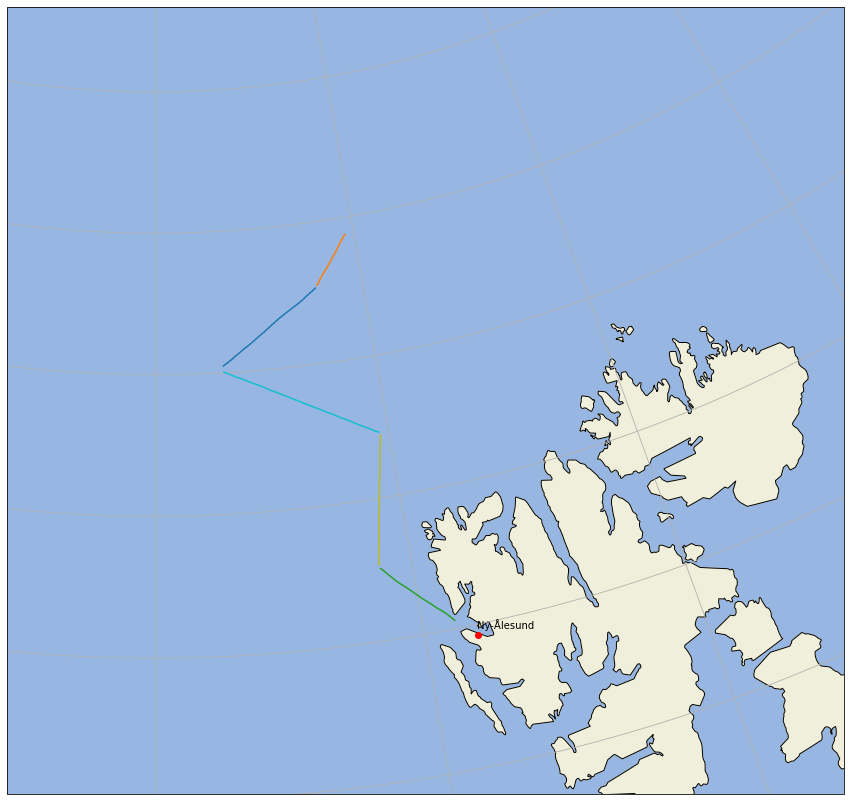

In [22]:
for l in lines:
    ll = l.pop(0)
    ll.remove()
    
lines = []
for q in queried:
    start = q['start']
    end   = q['end']
    
    line = ax.plot(ds_gps.lon.sel(time=slice(start, end)),
                   ds_gps.lat.sel(time=slice(start, end)),
                   transform=ccrs.PlateCarree())
    lines.append(line)
    
fig

In [23]:
queried = ds.selectDropSondes('BAD')

df = pd.DataFrame(queried)
df

,dropsondes,end,irregularities,kinds,levels,name,segment_id,start
0,"{'BAD': ['P5_RF14_sonde06'], 'GOOD': [], 'UGLY...",2017-06-08 11:52:57,[],[high_level],[9700],high level 8,ACLOUD_P5_RF14_hl08,2017-06-08 11:11:20


Plot the selected elements:

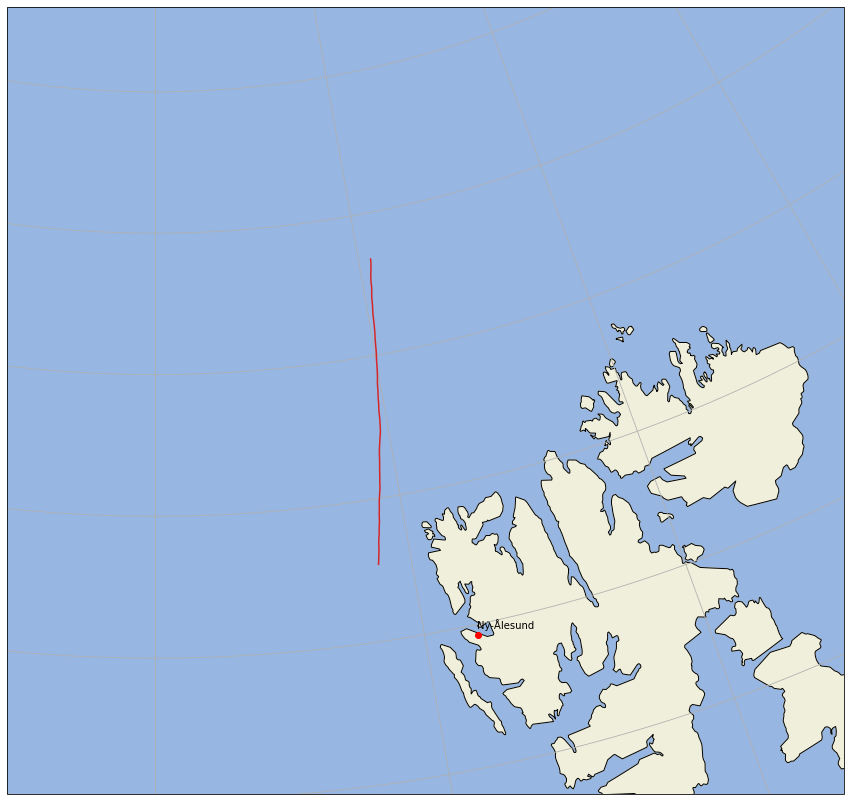

In [24]:
for l in lines:
    ll = l.pop(0)
    ll.remove()
    
lines = []
for q in queried:
    start = q['start']
    end   = q['end']
    
    line = ax.plot(ds_gps.lon.sel(time=slice(start, end)),
                   ds_gps.lat.sel(time=slice(start, end)),
                   transform=ccrs.PlateCarree())
    lines.append(line)
    
fig